In [1]:
# Import the classes
from thesisv3.classism import MusicFileManager, MusicSegmentAnalyzer, MusicVisualizer

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


D:\School\thesisv3\.venv\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [13]:
file_manager = MusicFileManager()
file_manager.display_selector()

In [35]:
analyzer = MusicSegmentAnalyzer()

In [36]:
analyzer.load_score(file_manager.selected_file)

FileNotFoundError: Cannot find file in .\music_database\Mozart_-_Piano_Sonata_No._11_K_331_3rd_Movement_Rondo_alla_Turca.mxl

In [30]:
analyzer.analyze_segments()

In [31]:
analyzer.preprocess_segments()

In [32]:
analyzer.calculate_distance_matrix()

Calculated Edge Weight (0, 1)
Calculated Edge Weight (0, 2)
Calculated Edge Weight (0, 3)
Calculated Edge Weight (0, 4)
Calculated Edge Weight (0, 5)
Calculated Edge Weight (0, 6)
Calculated Edge Weight (0, 7)
Calculated Edge Weight (0, 8)
Calculated Edge Weight (0, 9)
Calculated Edge Weight (0, 10)
Calculated Edge Weight (0, 11)
Calculated Edge Weight (0, 12)
Calculated Edge Weight (0, 13)
Calculated Edge Weight (0, 14)
Calculated Edge Weight (0, 15)
Calculated Edge Weight (0, 16)
Calculated Edge Weight (0, 17)
Calculated Edge Weight (0, 18)
Calculated Edge Weight (0, 19)
Calculated Edge Weight (0, 20)
Calculated Edge Weight (0, 21)
Calculated Edge Weight (0, 22)
Calculated Edge Weight (0, 23)
Calculated Edge Weight (0, 24)
Calculated Edge Weight (0, 25)
Calculated Edge Weight (0, 26)
Calculated Edge Weight (0, 27)
Calculated Edge Weight (0, 28)
Calculated Edge Weight (0, 29)
Calculated Edge Weight (0, 30)
Calculated Edge Weight (0, 31)
Calculated Edge Weight (0, 32)
Calculated Edge W

In [33]:
visualizer = MusicVisualizer(analyzer)

In [34]:
visualizer.visualize_colored_segments()

MusicXMLExportException: In part (Piano), measure (27): Cannot convert inexpressible durations to MusicXML.

In [10]:
visualizer.visualize_multiple_segments(5)

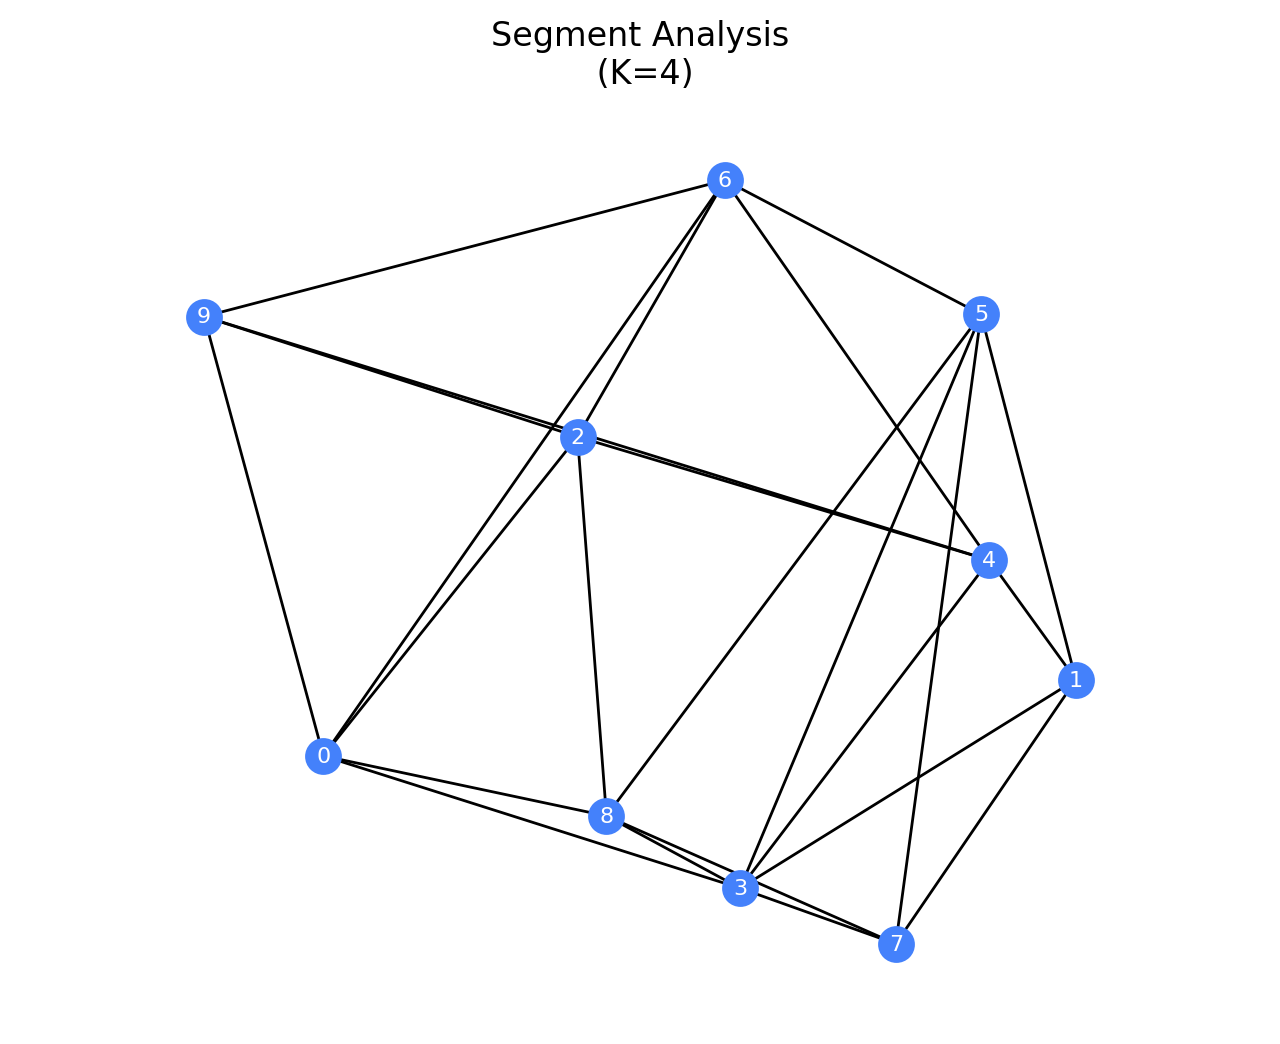

In [11]:
visualizer.visualize_knn_graph(k=4, title="Segment Analysis")

In [12]:
import numpy as np

def ismonophonic(nmat):
    """
    A simple check that the note matrix is monophonic.
    This version assumes that nmat is sorted by onset time and that
    the first two columns contain the note onset and offset.
    It returns False if any note overlaps the previous one.
    """
    if nmat.shape[0] < 2:
        return True
    # Assuming column 0 = onset and column 1 = offset
    for i in range(1, nmat.shape[0]):
        if nmat[i, 0] < nmat[i-1, 1]:
            return False
    return True

def mobility(nmat):
    """
    Compute the melodic mobility measure (von Hippel, 2000)
    for a notematrix. The mobility is computed using the lag‐1 
    autocorrelation of the pitch deviations from a running mean.
    
    Parameters
    ----------
    nmat : numpy.ndarray
        The note matrix. It is assumed that each row is a note,
        and that the pitch is stored in column 3 (i.e. index 2).
    
    Returns
    -------
    y : numpy.ndarray
        A column vector (2D array) of nonnegative mobility values,
        one value per note (with a zero prepended). (Because the 
        MATLAB code sets the first two values to zero, note that
        y[0]==y[1]==0.)
    
    Note
    ----
    Since the autocorrelation is always between -1 and 1 and the 
    pitch difference (in semitones) is used as a multiplier, the 
    mobility value (after taking the absolute value) is nonnegative.
    In theory its range is [0, ∞) but if pitches are MIDI numbers 
    (0–127) then the mobility will be bounded roughly by that range.
    """
    if nmat.size == 0:
        return np.array([])
    
    if not ismonophonic(nmat):
        print("mobility works only with monophonic input!")
        return np.array([])
    
    # Extract the pitch vector (assuming pitch is in column 3, i.e. index 2)
    pitches = nmat[:, 2]
    N = len(pitches)
    
    # Initialize lists to hold intermediate values.
    m_values = []  # running means for notes 1 to i-1
    p_list = []    # deviations for the previous note(s)
    # p2_list will be a list of length N; we set p2_list[0]=0
    p2_list = [0] * N  
    mob = [0] * N      # Will hold the lag‐1 correlation values (for indices 1..N-1)
    y = [0] * N        # Will hold the computed mobility values
    
    # Loop from i=1 to N-1 (which corresponds to MATLAB’s i=2:N)
    for i in range(1, N):
        # Compute the mean of all previous pitches (notes 0 to i-1)
        m_val = np.mean(pitches[:i])
        m_values.append(m_val)
        # Compute the deviation of the (i-1)th note from this mean.
        p_val = pitches[i-1] - m_val
        p_list.append(p_val)
        # Store this deviation in p2_list at index i
        p2_list[i] = p_val
        # In the MATLAB code, the vector z is created by concatenating p with
        # the current p_val again (i.e. duplicating the last element)
        z = p_list + [p_list[-1]]
        # Now take the first (i+1) elements of p2_list and z to form a 2-column array.
        p2_sub = np.array(p2_list[:i+1])
        z_sub = np.array(z)
        # Compute the correlation coefficient between p2_sub and z_sub.
        # If the standard deviation is zero (so the correlation is undefined), set r = 0.
        if np.std(p2_sub) == 0 or np.std(z_sub) == 0:
            r = 0
        else:
            r = np.corrcoef(p2_sub, z_sub)[0, 1]
        mob[i] = r
        # Compute the mobility value for the (i-1)th note.
        # (Note: The MATLAB code uses mob(i-1), which for i==1 is not defined,
        # so we use 0 in that case.)
        y[i-1] = mob[i-1] * (pitches[i] - m_val) if i-1 >= 0 else 0

    # After the loop, the MATLAB code sets the second element to 0
    if len(y) > 1:
        y[1] = 0
    # Prepend a 0 (so that the returned vector has one more element than computed in the loop)
    y = [0] + y
    # Finally, take the absolute value (to ensure nonnegative ratings)
    y = np.abs(np.array(y))
    # Return as a column vector
    return y.reshape(-1, 1)

# ---------------------------
# Example usage:
if __name__ == '__main__':
    # Create a simple example notematrix.
    # Here each row is a note with columns:
    # [onset, offset, pitch, ...]  (other columns may follow)
    # For example, we make a monophonic melody with 5 notes:
    nmat = np.array([
        [0.0, 0.5, 60],
        [0.6, 1.0, 62],
        [1.1, 1.5, 64],
        [1.6, 2.0, 65],
        [2.1, 2.5, 63]
    ])
    
    y = mobility(nmat)
    print("Mobility values:\n", y)


Mobility values:
 [[0.        ]
 [0.        ]
 [0.        ]
 [1.5       ]
 [0.20454545]
 [0.        ]]
